<a href="https://colab.research.google.com/github/Esteves4/IA-Proj/blob/main/IA_Proj_Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset import

**API Install**

In [ ]:
!pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



**Importing kaggle.json**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes


**Download dataset**

In [ ]:
!kaggle datasets download -d gpiosenka/musical-instruments-image-classification

 94% 192M/204M [00:01<00:00, 135MB/s]
100% 204M/204M [00:01<00:00, 149MB/s]


In [ ]:
!unzip -q musical-instruments-image-classification.zip

# Pre-processing

In [ ]:
import cv2
import pandas as pd 

basepath = "./"
music_df = pd.read_csv("instruments.csv")

dataset_info = pd.read_csv("class_dict.csv")

music_df.head()

,filepaths,labels,data set
0,train/acordian/001.jpg,acordian,train
1,train/acordian/002.jpg,acordian,train
2,train/acordian/003.jpg,acordian,train
3,train/acordian/004.jpg,acordian,train
4,train/acordian/005.jpg,acordian,train


**Instrument type preparation**

In [ ]:
dataset_info = pd.read_csv("class_dict.csv")

instrument_type = ["Woodwind", "Percussion", "Percussion", "Keyboard", "Woodwind", "Woodwind", "Strings", "Percussion", "Percussion", "Percussion", 
                   "Woodwind", "Strings", "Keyboard", "Percussion", "Strings", "Woodwind", "Percussion", "Strings", "Woodwind", "Strings", "Percussion",
                   "Woodwind", "Keyboard", "Woodwind", "Strings", "Percussion", "Brass", "Brass", "Brass", "Strings"]

dataset_info["Instrument_Type"] = instrument_type

dataset_info.head()

,class_index,class,height,width,scale by,Instrument_Type
0,0,Didgeridoo,224,224,1,Woodwind
1,1,Tambourine,224,224,1,Percussion
2,2,Xylophone,224,224,1,Percussion
3,3,acordian,224,224,1,Keyboard
4,4,alphorn,224,224,1,Woodwind


In [ ]:
merge_df = dataset_info[["class", "Instrument_Type"]]
music_df = pd.merge(music_df, merge_df, left_on='labels', right_on='class')
music_df = music_df.drop(['class'], axis=1)

music_df.head()

,filepaths,labels,data set,Instrument_Type
0,train/acordian/001.jpg,acordian,train,Keyboard
1,train/acordian/002.jpg,acordian,train,Keyboard
2,train/acordian/003.jpg,acordian,train,Keyboard
3,train/acordian/004.jpg,acordian,train,Keyboard
4,train/acordian/005.jpg,acordian,train,Keyboard


**Data visualization**

In [ ]:
import plotly.express as px

fig = px.histogram(music_df, x="labels")
fig.show()

In [ ]:
import plotly.express as px

fig = px.histogram(music_df, x="Instrument_Type")
fig.show()


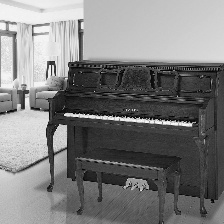
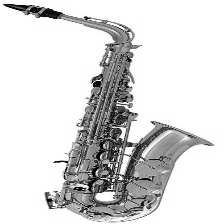
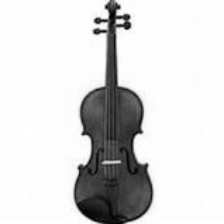
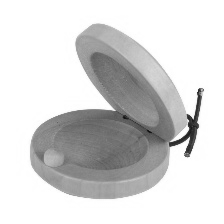
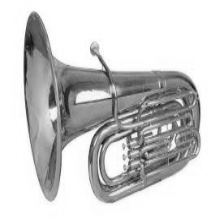

In [ ]:
import cv2
from plotly.subplots import make_subplots

class_list = music_df.Instrument_Type.unique().tolist()

fig = make_subplots(rows=1, cols=5, subplot_titles=class_list)

for n,i in enumerate(class_list):
  temp = music_df[music_df.Instrument_Type == i].sample()
  img = cv2.imread(basepath + temp.filepaths.values[0])
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  fig.add_trace(px.imshow(img).data[0], row=int(n/5)+1, col=n%5+1)

fig.show()

**Importing image in Dataframe**

In [ ]:
imgs = []

for index, row in music_df.iterrows():
  img = cv2.imread(basepath + row.filepaths)
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  imgs.append(gray)

music_df["Image_Data"] = imgs

# Feature Extraction

In [ ]:
def computeentropy(image):
  image = image.flatten()
  lensig=image.size
  symset=list(set(image.flatten()))
  numsym=len(symset)
  propab=[np.size(image[image==i])/(1.0*lensig) for i in symset]
  ent=np.sum([p*np.log2(1.0/p) for p in propab])
  return ent;

In [ ]:
import cv2
import numpy as np
from scipy.stats import kurtosis, skew

var = []
mean = []
std = []
entropy = []
img_skew = []
img_kurtosis = []


for index, row in music_df.iterrows():
  img = row.Image_Data.flatten()

  var.append(round(np.var(img),2))
  mean.append(round(np.mean(img),2))
  std.append(round(np.std(img),2))
  entropy.append(round(computeentropy(img),2))
  img_skew.append(round(skew(img),2))
  img_kurtosis.append(round(kurtosis(img),2))
  


music_df["var"] = var
music_df["mean"] = mean
music_df["std"] = std
music_df["entropy"] = entropy
music_df["skew"] = img_skew
music_df["kurtosis"] = img_kurtosis

**Correlation matrix of the features**

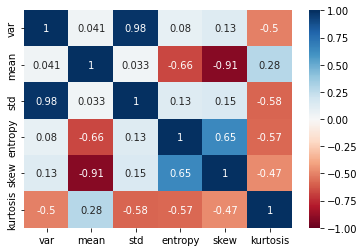

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

corr_data = music_df[["var","mean","std","entropy","skew","kurtosis"]]
corr_matrix = corr_data.corr()

sn.heatmap(corr_matrix, cmap='RdBu',vmin=-1, vmax=1, center=0, annot=True)
plt.show()

# Training

In [ ]:
# To use the music_df variable, features columns to use: var, mean, std, entropy, skew and kurtosis
#                             , class columns to use: labels, Instrument_Type
#                             , data column to be trainned:  Image_Data                            

music_df.head()

,filepaths,labels,data set,Instrument_Type,Image_Data,var,mean,std,entropy,skew,kurtosis
0,train/acordian/001.jpg,acordian,train,Keyboard,"[[254, 254, 254, 254, 254, 254, 254, 254, 254,...",6486.37,87.92,80.54,7.36,0.89,-0.67
1,train/acordian/002.jpg,acordian,train,Keyboard,"[[255, 254, 254, 254, 254, 255, 255, 255, 255,...",7045.55,141.26,83.94,7.45,0.04,-1.49
2,train/acordian/003.jpg,acordian,train,Keyboard,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",10224.17,162.43,101.11,5.68,-0.35,-1.72
3,train/acordian/004.jpg,acordian,train,Keyboard,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",10036.11,157.69,100.18,5.87,-0.28,-1.73
4,train/acordian/005.jpg,acordian,train,Keyboard,"[[254, 254, 254, 254, 254, 254, 254, 254, 254,...",9395.75,159.00,96.93,6.12,-0.26,-1.73


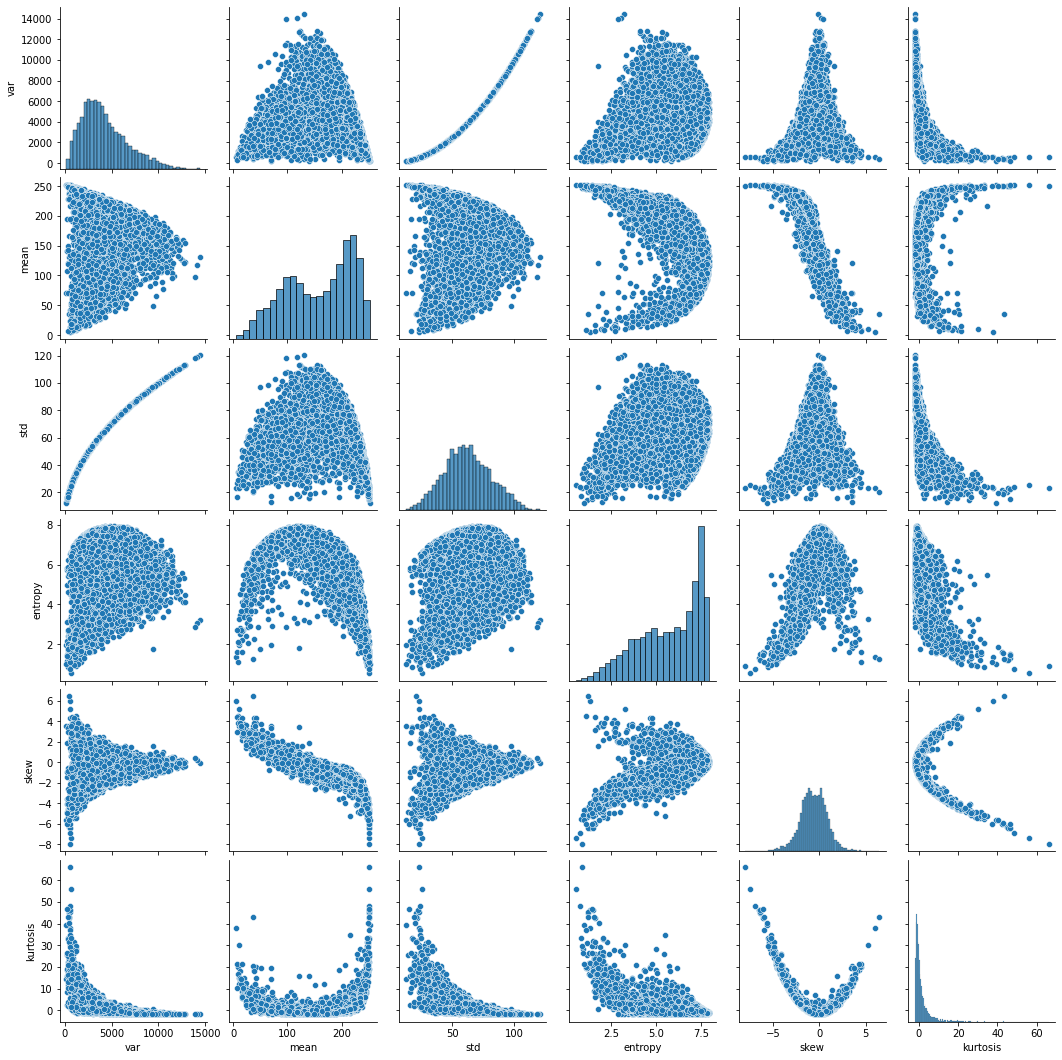

In [ ]:
#Hierarchical clustering
import seaborn as sns

sns.pairplot(music_df)

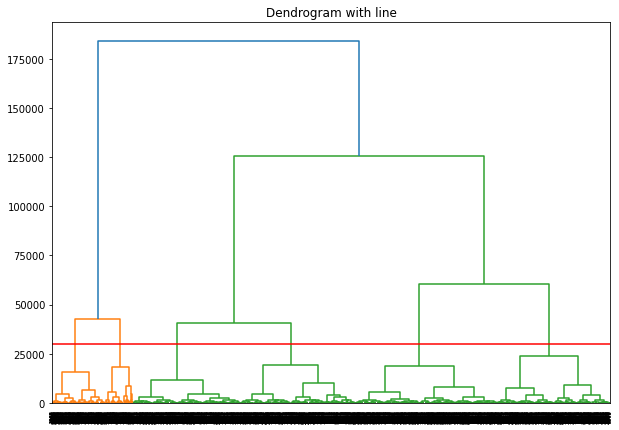

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Dendrogram with line")

trainning_df = music_df.drop(["filepaths", "labels", "data set", "Instrument_Type", "Image_Data"], axis=1)

clusters = shc.linkage(trainning_df, 
            method='ward', 
            metric="euclidean")

shc.dendrogram(clusters)

plt.axhline(y = 30000, color = 'r', linestyle = '-')

# Validation

# Test